In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('dataset/train.csv')

In [3]:
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [4]:
# create a function that will extract all the unique words from the dataset
def unique_words(df):
    unique_words = []
    for i in range(len(df)):
        for word in df['text'][i].split():
            if word not in unique_words:
                unique_words.append(word)
    return unique_words


In [5]:
arr = unique_words(df)

In [6]:
len(arr)

31924

In [7]:
# create a function that will create a dictionary of all the unique words and their frequency in the dataset
def word_freq(df):
    unique_words = []
    for i in range(len(df)):
        for word in df['text'][i].split():
            if word not in unique_words:
                unique_words.append(word)
    word_freq = {}
    for word in unique_words:
        word_freq[word] = 0
    for i in range(len(df)):
        for word in df['text'][i].split():
            word_freq[word] += 1
    return word_freq

In [8]:
word_dict = word_freq(df)

In [9]:
# do tokenization of all the words present in the dictionary
def tokenize_words(dictionary):
    tokens = {}
    ind = 0
    for word in dictionary:
        tokens[word] = ind
        ind += 1
    return tokens

In [10]:
tokens = tokenize_words(word_dict)

In [11]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

d:\Anaconda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submission = pd.read_csv('dataset/sample_submission.csv')

In [13]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
# create a dictionary which has id as keys and text as values
def create_dict(df):
    dict = {}
    for i in range(len(df)):
        dict[df['id'][i]] = df['text'][i]
    return dict

In [15]:
dict = create_dict(train)
#print(dict)

In [16]:
train.drop(['id','keyword', 'location'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [17]:
# how to find number of zeroes and ones in the target column
def count_zeroes_ones(target):
    zeroes = 0
    ones = 0
    for i in range(len(target)):
        if target[i] == 0:
            zeroes += 1
        else:
            ones += 1
    return zeroes, ones

In [18]:
zeroes, ones = count_zeroes_ones(train['target'])

<BarContainer object of 2 artists>

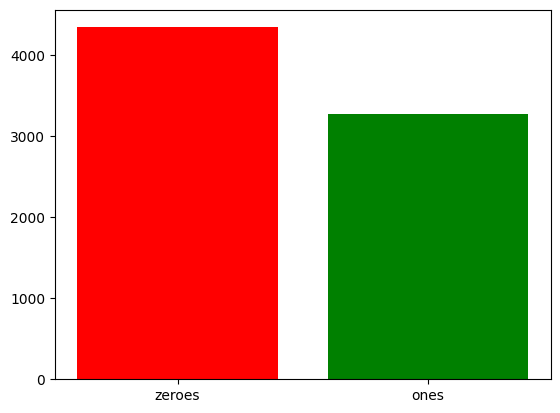

In [19]:
#plot a bar graph to show the distribution of the target column
import matplotlib.pyplot as plt
# change color of the bars
plt.bar(['zeroes', 'ones'], [zeroes, ones], color=['red', 'green'])


In [20]:
lablels = train['target'].tolist()
tweets = train['text'].tolist()

In [21]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

d:\Anaconda\envs\myenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aditya Singh\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [22]:
inputs = tokenizer(tweets, padding="max_length", truncation=True)

In [23]:
import torch

class twitterdataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [24]:
train_dataset = twitterdataset(inputs, lablels)

In [25]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [28]:
training_args = TrainingArguments(
    output_dir="./results",          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    # eval_dataset=test_dataset          # evaluation dataset
    # compute_metrics=compute_metrics    # define metrics function
)

trainer.train()

d:\Anaconda\envs\myenv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 10/1428 [03:38<8:38:29, 21.94s/it]

{'loss': 0.6954, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}


  1%|▏         | 20/1428 [07:31<9:25:30, 24.10s/it]

{'loss': 0.6886, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}


  2%|▏         | 30/1428 [11:51<9:59:51, 25.75s/it] 

{'loss': 0.6775, 'learning_rate': 3e-06, 'epoch': 0.06}


  3%|▎         | 40/1428 [16:04<9:26:18, 24.48s/it] 

{'loss': 0.6847, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}


  4%|▎         | 50/1428 [19:57<8:53:39, 23.24s/it]

{'loss': 0.6848, 'learning_rate': 5e-06, 'epoch': 0.11}


  4%|▍         | 60/1428 [23:49<8:44:04, 22.99s/it]

{'loss': 0.6518, 'learning_rate': 6e-06, 'epoch': 0.13}


  5%|▍         | 70/1428 [27:39<8:32:47, 22.66s/it]

{'loss': 0.636, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.15}


  6%|▌         | 80/1428 [40:46<23:59:01, 64.05s/it] 

{'loss': 0.6044, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.17}


  6%|▋         | 90/1428 [1:19:57<69:40:44, 187.48s/it] 

{'loss': 0.5403, 'learning_rate': 9e-06, 'epoch': 0.19}


  7%|▋         | 100/1428 [2:10:49<26:53:59, 72.92s/it] 

{'loss': 0.5706, 'learning_rate': 1e-05, 'epoch': 0.21}


  8%|▊         | 110/1428 [2:13:49<7:07:33, 19.46s/it] 

{'loss': 0.5051, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.23}


  8%|▊         | 120/1428 [2:16:51<6:36:46, 18.20s/it]

{'loss': 0.5392, 'learning_rate': 1.2e-05, 'epoch': 0.25}


  9%|▉         | 130/1428 [5:06:22<762:46:19, 2115.55s/it] 

{'loss': 0.4544, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.27}


 10%|▉         | 140/1428 [11:49:14<646:17:58, 1806.43s/it] 

{'loss': 0.4728, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.29}


 11%|█         | 150/1428 [11:52:53<25:45:52, 72.58s/it]   

{'loss': 0.4926, 'learning_rate': 1.5e-05, 'epoch': 0.32}


 11%|█         | 160/1428 [11:56:38<8:21:25, 23.73s/it] 

{'loss': 0.4484, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.34}


 12%|█▏        | 170/1428 [13:35:13<300:01:55, 858.60s/it] 

{'loss': 0.5222, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.36}


 13%|█▎        | 180/1428 [13:38:53<15:51:04, 45.72s/it]  

{'loss': 0.4636, 'learning_rate': 1.8e-05, 'epoch': 0.38}


 13%|█▎        | 190/1428 [13:42:41<8:05:22, 23.52s/it] 

{'loss': 0.3969, 'learning_rate': 1.9e-05, 'epoch': 0.4}


 14%|█▍        | 200/1428 [13:46:51<9:03:23, 26.55s/it]

{'loss': 0.4769, 'learning_rate': 2e-05, 'epoch': 0.42}


 15%|█▍        | 210/1428 [13:51:28<9:24:51, 27.83s/it]

{'loss': 0.4271, 'learning_rate': 2.1e-05, 'epoch': 0.44}


 15%|█▌        | 220/1428 [13:56:06<9:17:20, 27.68s/it]

{'loss': 0.4074, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.46}


 16%|█▌        | 230/1428 [14:00:45<9:15:45, 27.83s/it]

{'loss': 0.4568, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.48}


 17%|█▋        | 240/1428 [14:05:32<9:43:50, 29.49s/it]

{'loss': 0.5098, 'learning_rate': 2.4e-05, 'epoch': 0.5}


 18%|█▊        | 250/1428 [14:10:35<9:52:42, 30.19s/it]

{'loss': 0.4354, 'learning_rate': 2.5e-05, 'epoch': 0.53}


 18%|█▊        | 260/1428 [14:15:38<9:52:34, 30.44s/it]

{'loss': 0.44, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.55}


 19%|█▉        | 270/1428 [14:20:45<9:50:11, 30.58s/it]

{'loss': 0.4614, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.57}


 20%|█▉        | 280/1428 [14:25:52<9:46:27, 30.65s/it]

{'loss': 0.3907, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.59}


 20%|██        | 290/1428 [14:31:00<9:41:40, 30.67s/it]

{'loss': 0.3877, 'learning_rate': 2.9e-05, 'epoch': 0.61}


 21%|██        | 300/1428 [14:36:05<9:32:48, 30.47s/it]

{'loss': 0.4143, 'learning_rate': 3e-05, 'epoch': 0.63}


 22%|██▏       | 310/1428 [14:41:08<9:28:35, 30.51s/it]

{'loss': 0.4245, 'learning_rate': 3.1e-05, 'epoch': 0.65}


 22%|██▏       | 320/1428 [14:46:14<9:25:37, 30.63s/it]

{'loss': 0.4139, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.67}


 23%|██▎       | 330/1428 [14:51:21<9:20:43, 30.64s/it]

{'loss': 0.4914, 'learning_rate': 3.3e-05, 'epoch': 0.69}


 24%|██▍       | 340/1428 [14:56:26<9:10:39, 30.37s/it]

{'loss': 0.4294, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.71}


 25%|██▍       | 350/1428 [15:01:23<8:29:11, 28.34s/it]

{'loss': 0.4475, 'learning_rate': 3.5e-05, 'epoch': 0.74}


 25%|██▌       | 360/1428 [15:05:17<6:57:44, 23.47s/it]

{'loss': 0.4213, 'learning_rate': 3.6e-05, 'epoch': 0.76}


 26%|██▌       | 370/1428 [15:09:08<6:46:49, 23.07s/it]

{'loss': 0.4584, 'learning_rate': 3.7e-05, 'epoch': 0.78}


 27%|██▋       | 380/1428 [15:13:17<7:42:54, 26.50s/it]

{'loss': 0.3654, 'learning_rate': 3.8e-05, 'epoch': 0.8}


 27%|██▋       | 390/1428 [15:17:56<8:02:23, 27.88s/it]

{'loss': 0.4112, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.82}


 28%|██▊       | 400/1428 [15:22:36<7:58:08, 27.91s/it]

{'loss': 0.4504, 'learning_rate': 4e-05, 'epoch': 0.84}


 29%|██▊       | 410/1428 [15:27:16<7:52:36, 27.85s/it]

{'loss': 0.4358, 'learning_rate': 4.1e-05, 'epoch': 0.86}


 29%|██▉       | 420/1428 [15:31:25<6:39:37, 23.79s/it]

{'loss': 0.3634, 'learning_rate': 4.2e-05, 'epoch': 0.88}


 30%|███       | 430/1428 [15:35:16<6:24:03, 23.09s/it]

{'loss': 0.3623, 'learning_rate': 4.3e-05, 'epoch': 0.9}


 31%|███       | 440/1428 [15:39:08<6:19:27, 23.04s/it]

{'loss': 0.3446, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.92}


 32%|███▏      | 450/1428 [15:43:33<7:26:57, 27.42s/it]

{'loss': 0.3991, 'learning_rate': 4.5e-05, 'epoch': 0.95}


 32%|███▏      | 460/1428 [15:48:14<7:36:57, 28.32s/it]

{'loss': 0.3895, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.97}


 33%|███▎      | 470/1428 [15:52:56<7:31:36, 28.28s/it]

{'loss': 0.5122, 'learning_rate': 4.7e-05, 'epoch': 0.99}


 34%|███▎      | 480/1428 [15:57:36<7:24:02, 28.10s/it]

{'loss': 0.3933, 'learning_rate': 4.8e-05, 'epoch': 1.01}


 34%|███▍      | 490/1428 [16:02:19<7:22:07, 28.28s/it]

{'loss': 0.3633, 'learning_rate': 4.9e-05, 'epoch': 1.03}


 35%|███▌      | 500/1428 [16:07:01<7:18:26, 28.35s/it]

{'loss': 0.1798, 'learning_rate': 5e-05, 'epoch': 1.05}


 36%|███▌      | 510/1428 [16:11:11<6:12:40, 24.36s/it]

{'loss': 0.34, 'learning_rate': 4.946120689655172e-05, 'epoch': 1.07}


 36%|███▋      | 520/1428 [16:15:12<6:04:26, 24.08s/it]

{'loss': 0.5563, 'learning_rate': 4.892241379310345e-05, 'epoch': 1.09}


 37%|███▋      | 530/1428 [16:19:19<6:28:37, 25.97s/it]

{'loss': 0.3887, 'learning_rate': 4.838362068965517e-05, 'epoch': 1.11}


 38%|███▊      | 540/1428 [16:24:25<7:35:12, 30.76s/it]

{'loss': 0.3734, 'learning_rate': 4.78448275862069e-05, 'epoch': 1.13}


 39%|███▊      | 550/1428 [16:29:38<7:42:08, 31.58s/it]

{'loss': 0.3735, 'learning_rate': 4.730603448275862e-05, 'epoch': 1.16}


 39%|███▉      | 560/1428 [16:34:54<7:39:25, 31.76s/it]

{'loss': 0.4433, 'learning_rate': 4.6767241379310346e-05, 'epoch': 1.18}


 40%|███▉      | 570/1428 [16:40:22<7:47:06, 32.67s/it]

{'loss': 0.3277, 'learning_rate': 4.622844827586207e-05, 'epoch': 1.2}


 41%|████      | 580/1428 [16:45:48<7:35:09, 32.20s/it]

{'loss': 0.4296, 'learning_rate': 4.5689655172413794e-05, 'epoch': 1.22}


 41%|████▏     | 590/1428 [16:51:08<7:30:10, 32.23s/it]

{'loss': 0.3833, 'learning_rate': 4.515086206896552e-05, 'epoch': 1.24}


 42%|████▏     | 600/1428 [16:56:29<7:23:06, 32.11s/it]

{'loss': 0.367, 'learning_rate': 4.461206896551724e-05, 'epoch': 1.26}


 43%|████▎     | 610/1428 [17:02:11<7:19:48, 32.26s/it]

{'loss': 0.4398, 'learning_rate': 4.407327586206897e-05, 'epoch': 1.28}


 43%|████▎     | 620/1428 [17:10:39<12:29:16, 55.64s/it]

{'loss': 0.3935, 'learning_rate': 4.353448275862069e-05, 'epoch': 1.3}


 44%|████▍     | 630/1428 [17:29:22<52:21:22, 236.19s/it]

{'loss': 0.4079, 'learning_rate': 4.299568965517242e-05, 'epoch': 1.32}


 45%|████▍     | 640/1428 [17:36:42<9:38:17, 44.03s/it]  

{'loss': 0.3866, 'learning_rate': 4.245689655172414e-05, 'epoch': 1.34}


 46%|████▌     | 650/1428 [17:42:51<8:07:37, 37.61s/it]

{'loss': 0.3268, 'learning_rate': 4.1918103448275866e-05, 'epoch': 1.37}


 46%|████▌     | 660/1428 [17:52:50<18:49:04, 88.21s/it]

{'loss': 0.3722, 'learning_rate': 4.1379310344827587e-05, 'epoch': 1.39}


 47%|████▋     | 670/1428 [18:00:41<9:40:54, 45.98s/it] 

{'loss': 0.3782, 'learning_rate': 4.0840517241379314e-05, 'epoch': 1.41}


 48%|████▊     | 680/1428 [18:05:06<5:40:08, 27.28s/it]

{'loss': 0.4302, 'learning_rate': 4.0301724137931035e-05, 'epoch': 1.43}


 48%|████▊     | 690/1428 [18:09:39<5:26:17, 26.53s/it]

{'loss': 0.4016, 'learning_rate': 3.976293103448276e-05, 'epoch': 1.45}


 49%|████▉     | 700/1428 [18:14:01<5:22:53, 26.61s/it]

{'loss': 0.4119, 'learning_rate': 3.922413793103448e-05, 'epoch': 1.47}


 50%|████▉     | 710/1428 [18:18:30<5:22:19, 26.94s/it]

{'loss': 0.2883, 'learning_rate': 3.86853448275862e-05, 'epoch': 1.49}


 50%|█████     | 720/1428 [18:23:43<6:29:51, 33.04s/it]

{'loss': 0.344, 'learning_rate': 3.814655172413794e-05, 'epoch': 1.51}


 51%|█████     | 730/1428 [18:28:21<5:15:56, 27.16s/it]

{'loss': 0.4812, 'learning_rate': 3.760775862068966e-05, 'epoch': 1.53}


 52%|█████▏    | 740/1428 [18:32:44<5:03:45, 26.49s/it]

{'loss': 0.3191, 'learning_rate': 3.7068965517241385e-05, 'epoch': 1.55}


 53%|█████▎    | 750/1428 [18:37:09<4:59:59, 26.55s/it]

{'loss': 0.3312, 'learning_rate': 3.6530172413793106e-05, 'epoch': 1.58}


 53%|█████▎    | 760/1428 [18:41:30<4:47:46, 25.85s/it]

{'loss': 0.3489, 'learning_rate': 3.5991379310344833e-05, 'epoch': 1.6}


 54%|█████▍    | 770/1428 [18:45:51<4:45:58, 26.08s/it]

{'loss': 0.3741, 'learning_rate': 3.5452586206896554e-05, 'epoch': 1.62}


 55%|█████▍    | 780/1428 [18:50:09<4:38:11, 25.76s/it]

{'loss': 0.2938, 'learning_rate': 3.4913793103448275e-05, 'epoch': 1.64}


 55%|█████▌    | 790/1428 [18:54:21<4:23:40, 24.80s/it]

{'loss': 0.3546, 'learning_rate': 3.4375e-05, 'epoch': 1.66}


 56%|█████▌    | 800/1428 [18:58:40<4:38:32, 26.61s/it]

{'loss': 0.3037, 'learning_rate': 3.383620689655172e-05, 'epoch': 1.68}


 57%|█████▋    | 810/1428 [19:46:17<38:25:59, 223.88s/it] 

{'loss': 0.3437, 'learning_rate': 3.329741379310345e-05, 'epoch': 1.7}


 57%|█████▋    | 820/1428 [19:54:48<9:24:20, 55.69s/it]  

{'loss': 0.3169, 'learning_rate': 3.275862068965517e-05, 'epoch': 1.72}


 58%|█████▊    | 830/1428 [20:03:23<8:34:44, 51.65s/it]

{'loss': 0.2698, 'learning_rate': 3.22198275862069e-05, 'epoch': 1.74}


 59%|█████▉    | 840/1428 [20:12:07<8:15:24, 50.55s/it]

{'loss': 0.3885, 'learning_rate': 3.168103448275862e-05, 'epoch': 1.76}


 60%|█████▉    | 850/1428 [20:18:20<4:49:04, 30.01s/it]

{'loss': 0.3451, 'learning_rate': 3.1142241379310346e-05, 'epoch': 1.79}


 60%|██████    | 860/1428 [20:22:55<4:22:31, 27.73s/it]

{'loss': 0.2958, 'learning_rate': 3.060344827586207e-05, 'epoch': 1.81}


 61%|██████    | 870/1428 [20:27:57<5:05:28, 32.85s/it]

{'loss': 0.4123, 'learning_rate': 3.0064655172413798e-05, 'epoch': 1.83}


 62%|██████▏   | 880/1428 [20:33:53<5:00:33, 32.91s/it]

{'loss': 0.3124, 'learning_rate': 2.952586206896552e-05, 'epoch': 1.85}


 62%|██████▏   | 890/1428 [20:38:15<3:55:33, 26.27s/it]

{'loss': 0.306, 'learning_rate': 2.8987068965517246e-05, 'epoch': 1.87}


 63%|██████▎   | 900/1428 [20:42:46<4:09:11, 28.32s/it]

{'loss': 0.2912, 'learning_rate': 2.844827586206897e-05, 'epoch': 1.89}


 64%|██████▎   | 910/1428 [20:47:52<4:25:08, 30.71s/it]

{'loss': 0.421, 'learning_rate': 2.7909482758620694e-05, 'epoch': 1.91}


 64%|██████▍   | 920/1428 [20:53:03<4:25:31, 31.36s/it]

{'loss': 0.4655, 'learning_rate': 2.7370689655172414e-05, 'epoch': 1.93}


 65%|██████▌   | 930/1428 [20:58:15<4:18:23, 31.13s/it]

{'loss': 0.368, 'learning_rate': 2.6831896551724138e-05, 'epoch': 1.95}


 66%|██████▌   | 940/1428 [21:03:21<4:07:24, 30.42s/it]

{'loss': 0.3201, 'learning_rate': 2.6293103448275862e-05, 'epoch': 1.97}


 67%|██████▋   | 950/1428 [21:08:30<4:07:19, 31.05s/it]

{'loss': 0.3508, 'learning_rate': 2.5754310344827586e-05, 'epoch': 2.0}


 67%|██████▋   | 960/1428 [21:13:29<3:56:10, 30.28s/it]

{'loss': 0.2366, 'learning_rate': 2.521551724137931e-05, 'epoch': 2.02}


 68%|██████▊   | 970/1428 [21:18:28<3:47:53, 29.85s/it]

{'loss': 0.2672, 'learning_rate': 2.4676724137931034e-05, 'epoch': 2.04}


 69%|██████▊   | 980/1428 [21:23:27<3:44:24, 30.05s/it]

{'loss': 0.2516, 'learning_rate': 2.413793103448276e-05, 'epoch': 2.06}


 69%|██████▉   | 990/1428 [21:28:31<3:40:53, 30.26s/it]

{'loss': 0.1076, 'learning_rate': 2.3599137931034486e-05, 'epoch': 2.08}


 70%|███████   | 1000/1428 [21:32:58<3:12:15, 26.95s/it]

{'loss': 0.2346, 'learning_rate': 2.306034482758621e-05, 'epoch': 2.1}


 71%|███████   | 1010/1428 [21:37:02<2:41:45, 23.22s/it]

{'loss': 0.217, 'learning_rate': 2.2521551724137934e-05, 'epoch': 2.12}


 71%|███████▏  | 1020/1428 [21:40:50<2:37:47, 23.20s/it]

{'loss': 0.2021, 'learning_rate': 2.1982758620689654e-05, 'epoch': 2.14}


 72%|███████▏  | 1030/1428 [21:44:37<2:29:06, 22.48s/it]

{'loss': 0.3181, 'learning_rate': 2.144396551724138e-05, 'epoch': 2.16}


 73%|███████▎  | 1040/1428 [21:49:06<2:58:59, 27.68s/it]

{'loss': 0.2474, 'learning_rate': 2.0905172413793102e-05, 'epoch': 2.18}


 74%|███████▎  | 1050/1428 [21:53:45<2:56:10, 27.96s/it]

{'loss': 0.3388, 'learning_rate': 2.036637931034483e-05, 'epoch': 2.21}


 74%|███████▍  | 1060/1428 [21:58:26<2:52:13, 28.08s/it]

{'loss': 0.2282, 'learning_rate': 1.9827586206896554e-05, 'epoch': 2.23}


 75%|███████▍  | 1070/1428 [22:03:47<4:01:25, 40.46s/it]

{'loss': 0.186, 'learning_rate': 1.9288793103448278e-05, 'epoch': 2.25}


 76%|███████▌  | 1080/1428 [22:07:32<2:13:37, 23.04s/it]

{'loss': 0.1653, 'learning_rate': 1.8750000000000002e-05, 'epoch': 2.27}


 76%|███████▋  | 1090/1428 [22:48:11<18:20:09, 195.30s/it]

{'loss': 0.1917, 'learning_rate': 1.8211206896551726e-05, 'epoch': 2.29}


 77%|███████▋  | 1100/1428 [23:14:21<4:35:14, 50.35s/it]  

{'loss': 0.1571, 'learning_rate': 1.767241379310345e-05, 'epoch': 2.31}


 78%|███████▊  | 1110/1428 [23:18:09<2:04:16, 23.45s/it]

{'loss': 0.1642, 'learning_rate': 1.7133620689655174e-05, 'epoch': 2.33}


 78%|███████▊  | 1120/1428 [23:44:29<13:41:18, 160.00s/it]

{'loss': 0.3569, 'learning_rate': 1.6594827586206898e-05, 'epoch': 2.35}


 79%|███████▉  | 1130/1428 [23:48:08<2:08:41, 25.91s/it]  

{'loss': 0.2271, 'learning_rate': 1.6056034482758622e-05, 'epoch': 2.37}


 80%|███████▉  | 1140/1428 [23:51:49<1:47:25, 22.38s/it]

{'loss': 0.2061, 'learning_rate': 1.5517241379310346e-05, 'epoch': 2.39}


 81%|████████  | 1150/1428 [24:36:57<11:22:38, 147.33s/it]

{'loss': 0.1587, 'learning_rate': 1.497844827586207e-05, 'epoch': 2.42}


 81%|████████  | 1160/1428 [24:40:35<1:52:39, 25.22s/it]  

{'loss': 0.2645, 'learning_rate': 1.4439655172413794e-05, 'epoch': 2.44}


 82%|████████▏ | 1170/1428 [24:44:17<1:36:45, 22.50s/it]

{'loss': 0.1949, 'learning_rate': 1.3900862068965518e-05, 'epoch': 2.46}


 83%|████████▎ | 1180/1428 [25:08:39<4:32:13, 65.86s/it]  

{'loss': 0.2325, 'learning_rate': 1.336206896551724e-05, 'epoch': 2.48}


 83%|████████▎ | 1190/1428 [25:12:22<1:33:19, 23.53s/it]

{'loss': 0.2203, 'learning_rate': 1.2823275862068968e-05, 'epoch': 2.5}


 84%|████████▍ | 1200/1428 [25:16:09<1:26:17, 22.71s/it]

{'loss': 0.2179, 'learning_rate': 1.228448275862069e-05, 'epoch': 2.52}


 85%|████████▍ | 1210/1428 [25:44:23<4:28:52, 74.00s/it]  

{'loss': 0.2461, 'learning_rate': 1.1745689655172416e-05, 'epoch': 2.54}


 85%|████████▌ | 1220/1428 [25:48:05<1:22:09, 23.70s/it]

{'loss': 0.2621, 'learning_rate': 1.1206896551724138e-05, 'epoch': 2.56}


 86%|████████▌ | 1230/1428 [25:51:53<1:15:52, 22.99s/it]

{'loss': 0.2151, 'learning_rate': 1.0668103448275862e-05, 'epoch': 2.58}


 87%|████████▋ | 1240/1428 [26:26:24<2:22:50, 45.59s/it]  

{'loss': 0.2252, 'learning_rate': 1.0129310344827586e-05, 'epoch': 2.61}


 88%|████████▊ | 1250/1428 [26:30:03<1:07:03, 22.61s/it]

{'loss': 0.1681, 'learning_rate': 9.590517241379312e-06, 'epoch': 2.63}


 88%|████████▊ | 1260/1428 [26:33:46<1:02:36, 22.36s/it]

{'loss': 0.2346, 'learning_rate': 9.051724137931036e-06, 'epoch': 2.65}


 89%|████████▉ | 1270/1428 [26:37:46<1:07:08, 25.50s/it]

{'loss': 0.2605, 'learning_rate': 8.512931034482758e-06, 'epoch': 2.67}


 90%|████████▉ | 1280/1428 [26:42:14<1:06:13, 26.85s/it]

{'loss': 0.2749, 'learning_rate': 7.974137931034484e-06, 'epoch': 2.69}


 90%|█████████ | 1290/1428 [26:46:44<1:02:03, 26.98s/it]

{'loss': 0.2426, 'learning_rate': 7.435344827586208e-06, 'epoch': 2.71}


 91%|█████████ | 1300/1428 [26:51:14<57:46, 27.08s/it]  

{'loss': 0.1983, 'learning_rate': 6.896551724137932e-06, 'epoch': 2.73}


 92%|█████████▏| 1310/1428 [26:55:43<52:53, 26.89s/it]

{'loss': 0.2357, 'learning_rate': 6.357758620689655e-06, 'epoch': 2.75}


 92%|█████████▏| 1320/1428 [27:00:13<48:32, 26.97s/it]

{'loss': 0.2642, 'learning_rate': 5.81896551724138e-06, 'epoch': 2.77}


 93%|█████████▎| 1330/1428 [27:04:43<44:01, 26.95s/it]

{'loss': 0.1385, 'learning_rate': 5.280172413793104e-06, 'epoch': 2.79}


 94%|█████████▍| 1340/1428 [27:09:05<36:44, 25.05s/it]

{'loss': 0.1681, 'learning_rate': 4.741379310344828e-06, 'epoch': 2.82}


 95%|█████████▍| 1350/1428 [27:12:49<29:02, 22.34s/it]

{'loss': 0.2056, 'learning_rate': 4.202586206896552e-06, 'epoch': 2.84}


 95%|█████████▌| 1360/1428 [27:16:32<25:13, 22.26s/it]

{'loss': 0.2726, 'learning_rate': 3.6637931034482757e-06, 'epoch': 2.86}


 96%|█████████▌| 1370/1428 [27:20:33<24:27, 25.30s/it]

{'loss': 0.2195, 'learning_rate': 3.125e-06, 'epoch': 2.88}


 97%|█████████▋| 1380/1428 [27:24:22<18:15, 22.83s/it]

{'loss': 0.1743, 'learning_rate': 2.586206896551724e-06, 'epoch': 2.9}


 97%|█████████▋| 1390/1428 [27:28:05<14:10, 22.38s/it]

{'loss': 0.1756, 'learning_rate': 2.047413793103448e-06, 'epoch': 2.92}


 98%|█████████▊| 1400/1428 [27:31:49<10:41, 22.92s/it]

{'loss': 0.1833, 'learning_rate': 1.5086206896551726e-06, 'epoch': 2.94}


 99%|█████████▊| 1410/1428 [27:36:14<07:59, 26.65s/it]

{'loss': 0.2314, 'learning_rate': 9.698275862068966e-07, 'epoch': 2.96}


 99%|█████████▉| 1420/1428 [27:40:43<03:34, 26.84s/it]

{'loss': 0.172, 'learning_rate': 4.3103448275862073e-07, 'epoch': 2.98}


100%|██████████| 1428/1428 [27:43:59<00:00, 69.92s/it]

{'train_runtime': 99839.3155, 'train_samples_per_second': 0.229, 'train_steps_per_second': 0.014, 'train_loss': 0.35527614218180253, 'epoch': 3.0}


TrainOutput(global_step=1428, training_loss=0.35527614218180253, metrics={'train_runtime': 99839.3155, 'train_samples_per_second': 0.229, 'train_steps_per_second': 0.014, 'train_loss': 0.35527614218180253, 'epoch': 3.0})

In [29]:
def to_check_results(test_encoding):
    input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
    attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())

    return y

In [31]:
l2 = []
for i in test['text']:
    test_encoding = tokenizer(i, padding=True, truncation=True)
    input_ids = torch.tensor(test_encoding['input_ids']).to(device)
    attention_mask = torch.tensor(test_encoding['attention_mask']).to(device)
    op = to_check_results(test_encoding)
    l2.append(op)

In [46]:
submission['target'] = l2

In [47]:
submission.to_csv('dataset/submission_new.csv', index=False)